<a href="https://colab.research.google.com/github/sbarnesthornton/sepsis-prediction/blob/main/preprocessing_and_feature_extraction/sepsis_prediction_preprocessing_and_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns 
import matplotlib.pyplot as plt # matplotlib for plotting graphs

# %matplotlib inline renders plot inline on your page
%matplotlib inline

In [ ]:
# mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load full datasetA
df = pd.read_csv('/content/drive/MyDrive/sepsis-prediction/Dataset.csv')
df2 = pd.read_csv('/content/drive/MyDrive/sepsis-prediction/DatasetB.csv')

<ipython-input-3-4ca4b04d01d7>:3: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/drive/MyDrive/sepsis-prediction/DatasetB.csv')


In [ ]:
full_df = pd.concat([df,df2])

Text(0.5, 0, 'Column. Labels')

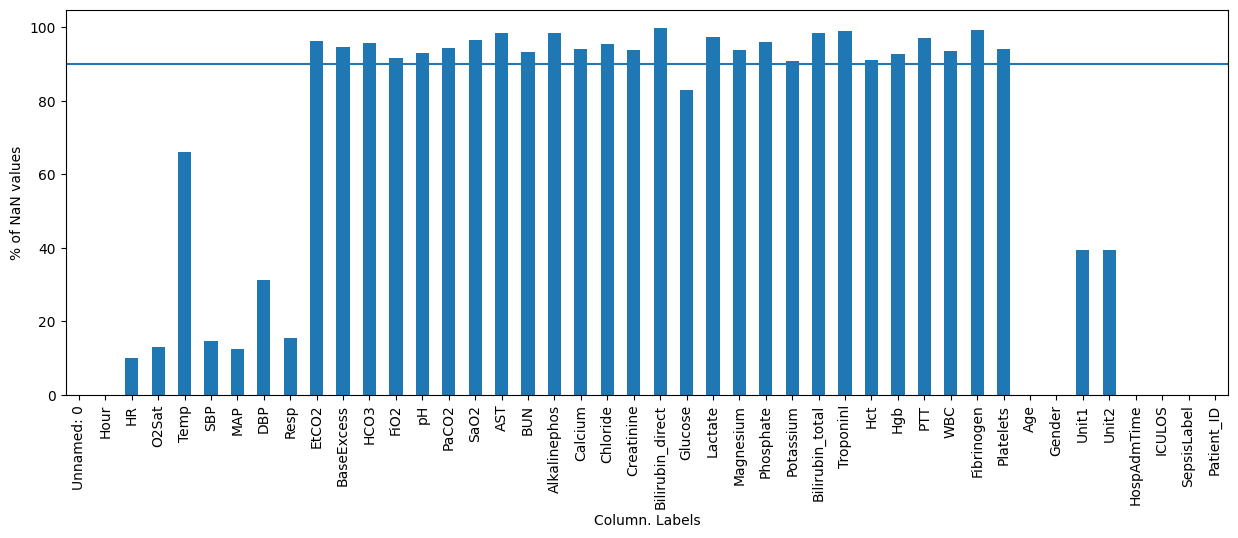

In [ ]:
round(100*(full_df.isnull().sum()/len(full_df.index)),2).plot.bar(figsize=(15,5))
plt.axhline(y=90)
plt.ylabel('% of NaN values')
plt.xlabel('Column. Labels')


In [ ]:
# num of rows with buggy label
has_parentheses = df2['Patient_ID'].astype(str).str.contains(r'\(\d+\)')
# remove rows with parentheses from df2
df2 = df2[~has_parentheses]

# reset the index of df2 after removing rows
df2 = df2.reset_index(drop=True)

max_id_df1 = df['Patient_ID'].max()

# increase the patient ids in df2 by max_id_df1 + 1
df2['Patient_ID'] = df2['Patient_ID'].astype(int) + max_id_df1 + 1

# combine the two datasets together
df2.index = range(len(df), len(df)+len(df2))

In [ ]:
from sklearn import feature_selection
def preprocess(dff, tol,dfid,developed):
  drop_these = ['Unnamed: 0','Unit1','Unit2']
  dff = dff.drop(drop_these, axis=1)
  if developed:
    septic_list = dff['Patient_ID'][dff['SepsisLabel']==1].unique()
    septic_df  = dff[dff.Patient_ID.isin(septic_list)]

    # Admitted with sepsis
    admitted_with_sepsis_list = dff['Patient_ID'][(dff['SepsisLabel']==1) & (dff['Hour']==0)].unique()

    # Develop sepsis
    mask = ~septic_df['Patient_ID'].isin(admitted_with_sepsis_list) # boolean mask  
    developed_sepsis_df = septic_df[mask]

    #Remove features that are missing completely in over 50% of patients
  
  # Group the DataFrame by the ID column
  grouped_by_ID = dff.groupby('Patient_ID')
  # Calculate the number of times each feature takes all NaN values for each ID
  no_patient_data = grouped_by_ID.apply(lambda x: x.isna().all()).sum().drop('Patient_ID')
  # expressed as percentage
  no_patient_data = no_patient_data/dff['Patient_ID'].nunique()

  # remove any features that arent available for over 70% of patients
  list_of_sparse_features = no_patient_data.loc[no_patient_data > tol].index.tolist()
  
  reduced_features = dff.drop(columns = list_of_sparse_features)
  
  constant = 0
  by_patient = reduced_features.groupby('Patient_ID')

  fragments = []
  for ID, features in by_patient:
    
    # create list of the features for differntial and sliding window analysis
    excluded = ['Patient_ID','SepsisLabel','ICULOS','HospAdmTime','Gender','Age','Hour']
    differential_list =  features.columns.difference(excluded).tolist()

    original_features = features.columns.tolist()

    
    # iterate through features
    for feat in original_features:
      # For all values prior to a first measurement, assign as constant. 
      first_non_nan = features[feat].first_valid_index()  

      if first_non_nan is not None and first_non_nan > features.index[0]:
        slice_size = first_non_nan - features.index[0]
        features.loc[features.index[0]:first_non_nan-1, feat] = [constant] * slice_size
        
      elif first_non_nan == None:
        # Assigns columns that are nan for all time as 0
        features[feat] = constant
      
      # For all remaining nans, foward fill
      features.ffill(inplace=True)

      # Add new columns for differential features and sliding window
      if feat in differential_list:
        #add lagged variables to capture time since last reading
        features[f'time_since_{feat}'] = np.nan
        
        count = 0
        for i in range(features.index[0], features.index[-1]+1):
          if i > features.index[0]:
            # If the current row has a reading for this feature
            if features.loc[i, feat] == features.loc[i-1, feat] and features.loc[i,feat] != 0:
              # Calculate the time since the last reading
              count +=1
              time_since_last_reading = count
              # Assign the time since the last reading to the new column
              features.loc[i, f'time_since_{feat}'] = time_since_last_reading
            elif features.loc[i, feat] != features.loc[i-1, feat] and features.loc[i,feat] != 0:
              # If the previous row does not have a reading for this feature, set the time since last reading to 0
              features.loc[i, f'time_since_{feat}'] = 0
              count = 0
            else:
              # If the current row does not have a reading for this feature, set the time since last reading to the constant value k
              features.loc[i, f'time_since_{feat}'] = -1000
        

        
        # differential feature: Looks at difference between that reading and the prev hour.
        features['d'+feat] = features[feat] - features[feat].shift(1)

        # rolling statistics: Looks back at prev 6 hours
        rolling_mean = features[feat].rolling(6, min_periods = 1).mean()
        rolling_max = features[feat].rolling(6, min_periods = 1).max()
        rolling_std = features[feat].rolling(6, min_periods = 1).std()
        rolling_min = features[feat].rolling(6, min_periods = 1).min()
      
        # adds rolling stats columns 
        features[f'{feat}_mean'] = rolling_mean
        features[f'{feat}_std'] = rolling_std
        features[f'{feat}_max'] = rolling_max
        features[f'{feat}_min'] = rolling_min 

        # percentiles
        percentiles = [0.25,0.5,0.75]
        for p in percentiles:
          features[f'{feat}_{p}_percentile'] = features[feat].rolling(6, min_periods = 1).quantile(p)
        
    # add the grouped dataframe to a list
    fragments.append(features)
  

  # combine patients to get full dataframe 
  filled_df = pd.concat(fragments)
  filled_df.fillna(value=0,inplace=True)

  return filled_df, list_of_sparse_features

In [ ]:
train_set, sparse1 = preprocess(df, 0.7,1,False)
test_set, sparse2 = preprocess(df2,0.7,2,False)

In [ ]:
# get common columns between df1 and df2
cols_to_drop = set(train_set.columns) - set(test_set.columns)
cols_to_drop2 = set(test_set.columns) - set(train_set.columns)

print(cols_to_drop)
print(cols_to_drop2)
test_set = test_set.reindex(columns=train_set.columns)
test_set = test_set.drop(cols_to_drop, axis=1)
train_set = train_set.drop(cols_to_drop, axis=1)

print(test_set.shape)
print(train_set.shape)
print(set(sparse1).union(set(sparse2)))

{'HCO3_mean', 'BaseExcess_std', 'BaseExcess_min', 'Chloride_max', 'BaseExcess_mean', 'Chloride_mean', 'BaseExcess_max', 'Chloride', 'BaseExcess', 'dHCO3', 'HCO3_std', 'HCO3_max', 'HCO3_min', 'dChloride', 'HCO3', 'Chloride_std', 'Chloride_min', 'dBaseExcess'}
{'EtCO2_std', 'TroponinI', 'EtCO2_min', 'TroponinI_min', 'EtCO2', 'TroponinI_max', 'EtCO2_mean', 'dEtCO2', 'TroponinI_mean', 'TroponinI_std', 'EtCO2_max', 'dTroponinI'}
(65568, 169)
(103196, 169)
{'Bilirubin_direct', 'TroponinI', 'Chloride', 'BaseExcess', 'EtCO2', 'HCO3', 'Fibrinogen'}


In [ ]:
# create a series that counts the hours since sepsislabel=1.

timeSepsis = train_set.groupby('Patient_ID')['SepsisLabel'].cumsum()

timeSepsis

778787    0
778788    0
778789    0
778790    0
778791    0
         ..
37527     5
37528     6
37529     7
37530     8
37531     9
Name: SepsisLabel, Length: 103196, dtype: int64

In [ ]:
# count number of rows with label value 1
num_sepsis = train_set['SepsisLabel'].sum()

# randomly select subset of rows with label value 0
df1_no_sepsis = train_set[train_set['SepsisLabel'] == 0].sample(n=num_sepsis, random_state=42)

# concatenate downsampled df1 with original df1 with label value 1
df1_downsampled = pd.concat([train_set[train_set['SepsisLabel'] == 1], df1_no_sepsis])

# shuffle the downsampled dataframe
train_set = df1_downsampled.sample(frac=1, random_state=42)

In [ ]:
def my_test_train_split(dfff,trainratio):
  # determine the unique patient IDs in the dataframe
  unique_patient_ids = dfff['Patient_ID'].unique()
  # calculate the number of patients to include in the training set
  num_train_patients = int(len(unique_patient_ids) * trainratio)
  

  # get the first num_train_patients patient IDs for the training set
  train_patient_ids = unique_patient_ids[:num_train_patients]


  # create boolean masks for the training and test sets based on the patient IDs
  train_mask = dfff['Patient_ID'].isin(train_patient_ids)

  test_mask = ~train_mask

  # create the training and test dataframes based on the masks
  train_df = dfff[train_mask]
  train_y = train_df['SepsisLabel']
  train_X = train_df.drop('SepsisLabel', axis = 1)
  test_df = dfff[test_mask]
  
  test_y = test_df['SepsisLabel']
  test_X = test_df.drop('SepsisLabel', axis = 1)

  test_patientID = test_X['Patient_ID']
  train_patientID = train_X['Patient_ID']

  drop_list = ['Patient_ID','ICULOS','HospAdmTime','Hour']
  train_X = train_X.drop(drop_list, axis = 1)
  test_X = test_X.drop(drop_list, axis = 1)


  return train_y, train_X, test_y, test_X, train_patientID, test_patientID

In [ ]:
# Seperate into features and labels

train_y = train_set['SepsisLabel']
train_X = train_set.drop('SepsisLabel', axis = 1)

drop_list = ['Patient_ID','ICULOS','HospAdmTime','Hour']
train_X = train_X.drop(drop_list, axis = 1)

#test_y = test_set['SepsisLabel']
#test_X = test_set.drop('SepsisLabel', axis = 1)
#test_X = test_X.drop(drop_list, axis = 1)

In [ ]:
# create validation and test sets
val_y, val_X, test_y, test_X, val_patient_ID, test_patient_ID = my_test_train_split(test_set,0.5)